## libs 

In [1]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
import matplotlib.pylab as plab

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from pathlib import Path
from tqdm import tqdm

## initialization

In [2]:
MODEL_DIRECTORY = Path('../../model/')

In [3]:
def get_stars_with_mass(table, name):
    
    main_component = pd.DataFrame(columns=table.columns, index=[0])
    
    for M_1 in table.columns:
        stars = pd.DataFrame(data={'q' : table.index})
        stars['M_2'] = float(M_1) * stars['q']
        
        stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
        stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
        stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])

        G_1 = interp(isochrone['Mini'], isochrone['Gmag'], M_1)
        BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], M_1) 
        RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], M_1)

        stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
        stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                              (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))


        if name == 'g':
            table[M_1] = stars['G, mag'].tolist()
            main_component[M_1] = G_1

        elif name == 'color':
            table[M_1] = stars['BP-RP, mag'].tolist()
            main_component[M_1]= BP_1 - RP_1
        else:
            raise ValueError('wrong name') 

    table = main_component.append(table, ignore_index=False)
    return table


def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def gauss(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

In [4]:
isochrone = pd.read_csv(MODEL_DIRECTORY / (f'isochrone_model_8.38.txt'), delimiter='\\s+')

## qM coordinates grid

In [5]:
q_array = np.linspace(0.1, 1, 101)
M_array = np.geomspace(0.9, 3, 201)

g_table = pd.DataFrame(columns = M_array, index=q_array)
color_table = pd.DataFrame(columns = M_array, index=q_array)

In [6]:
g_table = get_stars_with_mass(g_table, 'g')
color_table = get_stars_with_mass(color_table, 'color')

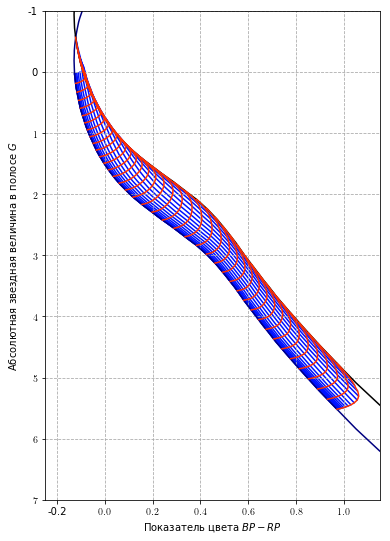

In [7]:
fig, ax = plt.subplots(figsize=(6,9))

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')


colors = plab.cm.jet(np.linspace(0,1,8))

ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'], label='isochrone', color=colors[0])
ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'] - 2.5*np.log10(2), 
        label='isochrone for binaries-twins', color='black')
for i in range(0, 100, 5):
    ax.plot(color_table.iloc[i, :], g_table.iloc[i, :], color=colors[1], label=None, lw=1.5, zorder=1) 
for i in range(0, 200, 5):
    ax.plot(color_table.iloc[:, i], g_table.iloc[:, i], color=colors[6], label=None, lw=1.5, zorder=2)

ax.grid(c='#aaaaaa', ls='--')

plt.xlabel(r'Показатель цвета $BP-RP$')
plt.ylabel(r'Абсолютная звездная величина в полосе $G$', labelpad=8)

#plt.yticks(np.arange(0.8,1.7, step=0.2))
ax.set_xlim(-0.25,1.15)
ax.set_ylim(-1,7)

ax.invert_yaxis()

ax.tick_params(axis='both', which='major')
#ax.legend(loc='upper right')
plt.savefig(MODEL_DIRECTORY / 'plots' / 'qM_coordinate_grids.pdf', bbox_inches = 'tight')

## new coordinates definition for model stars 

In [8]:
model_stars = read_file(MODEL_DIRECTORY / 'model_stars_500pc_manystars_flat.txt')
model_stars = model_stars[(model_stars['BP-RP, mag'] < 1.0) & (model_stars['BP-RP, mag'] > 0)]

M_1 = np.ndarray((len(model_stars+1)))
q = np.ndarray((len(model_stars+1)))

In [9]:
model_stars.reset_index(inplace=True)

In [10]:
for i in tqdm(range(len(model_stars))):
    g = model_stars.loc[i,'G, mag']
    color = model_stars.loc[i,'BP-RP, mag']

    g_difference = (g_table - g) * (g_table - g)
    color_difference = (color_table - color) * (color_table - color)
    
    distance = g_difference + color_difference
    M_1[i] = distance.min().idxmin()
    q[i] = distance[M_1[i]].idxmin()

100%|██████████| 3928/3928 [11:16<00:00,  5.68it/s]


In [11]:
model_stars['M_1_detected'] = M_1
model_stars['q_detected'] = q

In [12]:
model_stars['q'] = model_stars['Mass2'] / model_stars['Mass1']
model_stars['q'] = model_stars['q'].fillna(0)

# results analysis 

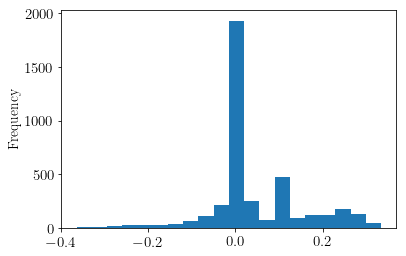

In [13]:
model_stars['q_difference'] = model_stars['q_detected'] - model_stars['q']
model_stars['q_difference'].plot.hist(bins=20)

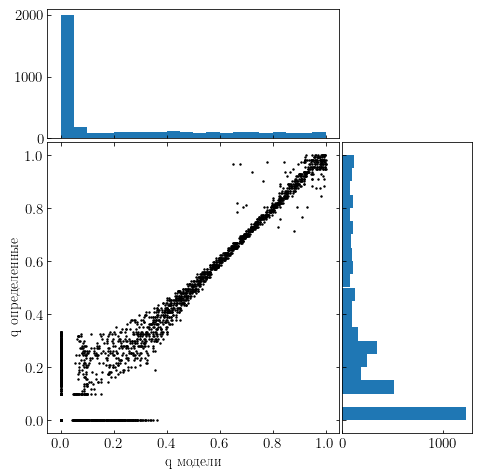

In [14]:
# the random data
x = model_stars['q']
y = model_stars['q_detected']

# definitions for the axes
left, width = 0.1, 0.45
bottom, height = 0.1, 0.45
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(9, 9))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y, s=2, c='black')
ax_scatter.set_xlabel('q модели', fontsize=15)
ax_scatter.set_ylabel('q определенные', fontsize=15)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth + 0.05
ax_scatter.set_xlim((-0.05, lim))
ax_scatter.set_ylim((-0.05, lim))

bins = 20
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

# ax_histx.set_xlim(ax_scatter.get_xlim())
# ax_histy.set_ylim(ax_scatter.get_ylim())
plt.savefig(MODEL_DIRECTORY / 'plots' / 'q_distributions.pdf',  bbox_inches = 'tight')

In [23]:
mask_s = (model_stars['q'] == 0)
mask_b = (model_stars['q'] != 0)

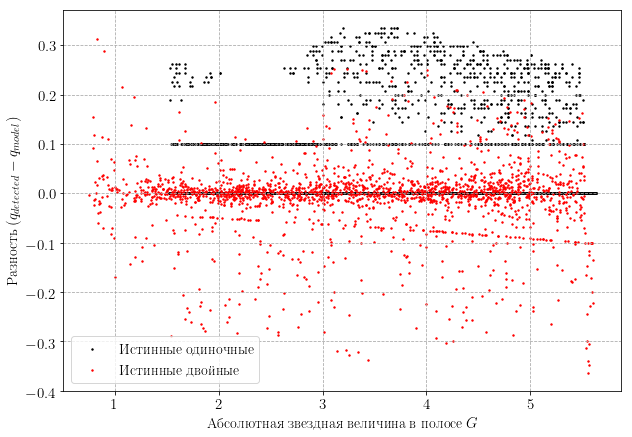

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(model_stars[mask_s]['G, mag'], model_stars[mask_s]['q_difference'], c='black', s=2, label='Истинные одиночные')
ax.scatter(model_stars[mask_b]['G, mag'], model_stars[mask_b]['q_difference'], c='red', s=2, label='Истинные двойные')

ax.set_xlabel(r'Абсолютная звездная величина в полосе $G$')
ax.set_ylabel(r'Разность $(q_{detected} - q_{model})$')

ax.grid(c='#aaaaaa', ls='--')
ax.legend()
ax.tick_params(axis='both', which='major')
plt.savefig(MODEL_DIRECTORY / 'plots' / 'difference_q(G).pdf',  bbox_inches = 'tight')

In [ ]:
mask_0 = (model_stars['BP-RP, mag'] < 0.25) 
mask_1 = (model_stars['BP-RP, mag'] > 0.25) & (model_stars['BP-RP, mag'] < 0.5) 
mask_2 = (model_stars['BP-RP, mag'] < 0.75) & (model_stars['BP-RP, mag'] > 0.5) 
mask_3 = (model_stars['BP-RP, mag'] > 0.75)

In [ ]:
model_stars[mask_3]['q_difference'].plot.hist()

## splitting in intervals (BP-RP) of equal size

In [ ]:
group_size = 491
model_stars.sort_values(by = 'BP-RP, mag', inplace=True)
num_groups = int(len(model_stars)/group_size) 

if num_groups * group_size < len(model_stars):
    num_groups += 1

In [ ]:
group_labels = np.arange(num_groups)
group_labels = np.repeat(group_labels, group_size)
group_labels = group_labels[0:len(model_stars)]

model_stars['label'] = group_labels

In [ ]:
dictionary = {}
for i in model_stars['label'].unique():
    mask = (model_stars['label'] == i)
    dictionary[i]= pd.Interval("%.2f" % model_stars['BP-RP, mag'][mask].min(), "%.2f" %model_stars['BP-RP, mag'][mask].max(), closed='both')

In [ ]:
profile_color = pd.DataFrame(data = {'x' : np.linspace(-1, 1, 701)})
for label in tqdm(model_stars['label'].to_numpy()):
    bin_stars = model_stars[model_stars['label'] == label]
    num_stars = len(bin_stars)
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.07)
    kde.fit(bin_stars[['q_difference']].to_numpy())
    
    profile_color[f'{dictionary[label]}'] = np.exp(kde.score_samples(profile_color[['x']].to_numpy())) 
    profile_color[f'{dictionary[label]}'] *= num_stars

In [ ]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

for i in range(1, num_groups+1):
    plt.subplot(2, 4, i)
    plt.plot(profile_color['x'], profile_color.iloc[:,i], lw = 1.1, color = 'black', 
             label=profile_color.columns[i])
    plt.xticks(np.arange(-0.5, 0.77, step=0.25))
    plt.xlim(-0.5, 0.77)
      
    plt.legend(loc='upper right')
    plt.xlabel('$(BP-RP)_{new}$')
plt.subplots_adjust(top=1.4, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)


## splitting in intervals (q) of equal size

In [ ]:
group_size = 389
model_stars.sort_values(by = 'q', inplace=True)
num_groups = int(len(model_stars[model_stars['q'] >0])/group_size) 

if num_groups * group_size < len(model_stars[model_stars['q'] >0]):
    num_groups += 1

In [ ]:
num_in_group = [len(model_stars[model_stars['q'] ==0]), group_size, group_size,group_size, group_size, group_size]
group_labels = np.repeat([0,1,2,3,4,5], num_in_group)
#group_labels = group_labels[0:len(model_stars[model_stars['q'] >0])]

model_stars['label_q'] = group_labels

In [ ]:
dictionary = {}
for i in model_stars['label_q'].unique():
    mask = (model_stars['label_q'] == i)
    dictionary[i]= pd.Interval("%.2f" % model_stars['q'][mask].min(), "%.2f" % model_stars['q'][mask].max(), closed='both')

In [ ]:
profile = pd.DataFrame(data = {'x' : np.linspace(-0.75, 0.75, 501)})
for label in tqdm(model_stars['label_q'].to_numpy()):
    bin_stars = model_stars[model_stars['label_q'] == label]
    num_stars = len(bin_stars)
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.07)
    kde.fit(bin_stars[['q_difference']].to_numpy())
    
    profile[f'{dictionary[label]}'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
    profile[f'{dictionary[label]}'] *= num_stars

In [ ]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

for i in range(1, num_groups+2):
    plt.subplot(2, 3, i)
    plt.plot(profile['x'], profile.iloc[:,i], lw = 1.1, color = 'black', label=profile.columns[i])
    plt.xticks(np.arange(-0.5, 0.77, step=0.25))
    plt.xlim(-0.5, 0.77)
      
    plt.legend(loc='upper right')
    plt.xlabel('$(q_{detected} - q_{model})$')
plt.subplots_adjust(top=1.4, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

plt.savefig(MODEL_DIRECTORY / 'plots' / 'q_difference_profiles.pdf', bbox_inches = 'tight')